## Clustering each segment using metafeatures in VSM

In [1]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import itertools
import scipy.fftpack as fft
from scipy.stats import norm, skew, kurtosis
from scipy.signal import butter, lfilter, filtfilt
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from collections import defaultdict, Counter, OrderedDict
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval
from operator import itemgetter
from detect_peaks import detect_peaks

Populating the interactive namespace from numpy and matplotlib


## Auxiliary functions

In [2]:
class MetafeatureVector():
    """Upon call to store, organize the data in 
    a dictionary. Convenient for using with csv.DictWriter."""
    def __init__(self):
        self.rows = defaultdict(dict)

    def store(self,d,func):
        """Each new value of a function is stored in a list
        for the given attibute."""
        for k,v in d.items():
            self.rows[k][func] = float("{:.2f}".format(v))
        
    def getData(self):
        """Return dictionary where each key is the atribute
        and its value a dictionary containing the metafeatures
        calculated"""
        return self.rows

In [3]:
def flatten_dict(dd, separator='.', prefix=''):
    """This function collapses a dictionary into a list, by appending
    the keys' values to themselves. That is, parents(keys) are joined together
    with children (values) by the separator variable.
    dd  :   dictionary to be flattened
    separator   :   the character used to join values to their keys.
    prefix      :   the character used in place of the value.
    """
    return {prefix + separator + k if prefix else k: v
            for kk, vv in dd.items()
            for k, v in flatten_dict(vv, separator, kk).items()
            } if isinstance(dd, dict) else {prefix: dd}

In [4]:
def find_subsequence(seq, subseq):
    target = np.dot(subseq, subseq)
    candidates = np.where(np.correlate(seq,
                                       subseq, mode='valid') == target)[0]
    # some of the candidates entries may be false positives, double check
    check = candidates[:, np.newaxis] + np.arange(len(subseq))
    mask = np.all((np.take(seq, check) == subseq), axis=-1)
    return candidates[mask]

In [5]:
def gridOfPlots(data, suptitle="Grid of plot"):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                row[j].set_title("Plot {}".format(count), fontsize=8, fontweight="bold")
                row[j].set_ylabel('g\'s (9.8 m/s^2)')
                row[j].plot(data[count])
                row[j].grid()
                count += 1

    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.5, wspace= 0.4)
    plt.draw()

## Meta-features function definition

In [6]:
def mean(data):
    """Calculates mean of the data"""
    return np.mean(data)

def std(data):
    """Calculates the standard deviation"""
    return np.std(data)

def max_min(data):
    """Calculate the max - min."""
    return np.max(data) - np.min(data)

def max_value(data):
    """ Calculates Largest value in array"""
    return np.max(data)
    
def min_value(data):
    """Calculates smallest value in array"""
    return np.min(data)

def mad(data, axis=None):
    """ 
    Calculates the median absolute deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    return np.median(np.absolute(data - np.median(data, axis)), axis)


def sma(data):
    """Computes Signal magnitude area.
    http://dsp.stackexchange.com/questions/18649/signal-magnitude-area
    """
    accumulator = np.sum([np.abs(x) for x in data])
    return accumulator / float(len(data))


def energy(data):
    """Energy measure. Sum of the squares divided by the number of values."""
    return np.sum([x**2 for x in data]) / float(len(data))


def iqr(data):
    """Calculates the interquartile range
    http://stackoverflow.com/questions/23228244/how-do-you-find-the-iqr-in-numpy
    """
    return np.subtract(*np.percentile(data, [75, 25]))

def maxInds(data, n_bins=200):
    """Returns the index of the frequency component with largest magnitude"""
    
    mean_sig = np.ones_like(data)*np.mean(data)
    # remove mean of the signal, for better results.
    sig = data - mean_sig
    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    #get max index in the freq domain
    return np.where(np.abs(half_freq_domain)==(max(np.abs(half_freq_domain))))[0][0]

def meanFreq(data, n_bins=200):
    """
    Weighted average of the frequency components to obtain a mean frequency
    http://luscinia.sourceforge.net/page26/page35/page35.html
    """
    mean_sig = np.ones_like(data)*np.mean(data)
    # remove mean of the signal, for better results.
    sig = data - mean_sig
    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    return np.sum(np.abs(half_freq_domain) * range(len(half_freq_domain))) / sum(np.abs(half_freq_domain))

def skewness(data):
    return skew(data)

def kurtos(data):
    return kurtosis(data)

def freq_skewness(data, n_bins=200): 
    """skewness of the frequency domain signal"""
    mean_sig = np.ones_like(data)*np.mean(data)
    # remove mean of the signal, for better results.
    sig = data - mean_sig
    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    return skew(np.abs(half_freq_domain))

def freq_kurtos(data, n_bins=200):
    """kurtosis of the frequency domain signal"""
    mean_sig = np.ones_like(data)*np.mean(data)
    # remove mean of the signal, for better results.
    sig = data - mean_sig
    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    return kurtosis(np.abs(half_freq_domain))

def num_peaks(data):
    """Return the number of peaks found on the data"""
    return len(detect_peaks(data, mpd=10, show=False))

def moving_rmsV1(x, window):
    """Moving RMS of 'x' with window size 'window'."""
    window = 2*window + 1
    return np.sqrt(np.convolve(x*x, np.ones(window)/window, 'same'))

def rms(data):
    """Return the root mean square of the sequence"""
    return np.sum(np.square(data))/len(data)

def correlation(t1,t2): 
    """correlation coefficient between two accelerometer signals"""
    data = {'data1':t1,'data2':t2}
    cor = pd.DataFrame.from_dict(data).corr().to_dict()['data1']['data2']
    return cor

In [7]:
function_dispatcher = {
    "mean"     : mean,
    "std"      : std,
    "max"      : max_value,
    "min"      : min_value,
    "mad"      : mad,
    "sma"      : sma,
    "iqr"      : iqr,
    "energy"   : energy,
    "maxInds"  : maxInds,
    "meanFreq" : meanFreq,
    "skewness" : skewness,
    "kurtosis" : kurtos,
    "freq_skewness" : freq_skewness,
    "freq_kurtosis" : freq_kurtos,
    "num_peaks"     : num_peaks,
    "moving_rmsV1"  : moving_rmsV1,
    "rms"           : rms,
    "max_min"       : max_min
}

In [8]:
def get_metafeat_vector(segment, mf=["mean","std","max","min","mad","sma",
                                        "iqr","energy","maxInds","meanFreq","skewness","kurtosis"]):
    """
        Compute metafeatures from segment data.
    
        segment : the time series segment
        mf      : list of metafeatures functions to be computed on the segment data.
    """
    
    meta_vector = OrderedDict()

    for f in mf:
        try:
            func = function_dispatcher[f]          # retrieve function
            meta_vector[f] = func(segment)    # compute function on segment.
        except KeyError:
            raise ValueError('Invalid function: {}'.format(f))

    return meta_vector
    

## Load CSV files

In [9]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [10]:
def loadFile(file_name, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(csv_dir, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [11]:
csv_dir = "./data"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))

>> 34 CSV Files found:



In [12]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)
failed_files = []
time_intervals = {}     ## where we keep the time information.
for f in files:
    csv_filename = f
    file_data = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    # load the data, abort in case of error.
    try:
        file_data = loadFile(csv_filename)
    except ValueError as e:
        print traceback.format_exc()
        failed_files.append(csv_filename)
        continue

    for i, w in enumerate(file_data):
        values = list(set(w['time']) - set(file_data[i-1]['time']))
        time_interval = w['time'].iloc[-1]
    time_intervals[f] = time_interval
    print '-- Time interval: {}'.format(time_interval)

print 'DONE!'

-- Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
-- Retrieved 24 windows in _2016-11-23-18-49-13_exp1_Player.csv
-- Time interval: 37.49
-- Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
-- Retrieved 28 windows in _2016-11-23-18-49-13_exp2_Player.csv
-- Time interval: 43.5
-- Processing: "_2016-11-23-18-49-13_exp3_Player.csv"
-- Retrieved 12 windows in _2016-11-23-18-49-13_exp3_Player.csv
-- Time interval: 19.48
-- Processing: "_2016-11-23-18-49-13_exp4_Player.csv"
-- Retrieved 23 windows in _2016-11-23-18-49-13_exp4_Player.csv
-- Time interval: 35.99
-- Processing: "_2016-11-23-18-49-13_exp5_Player.csv"
-- Retrieved 27 windows in _2016-11-23-18-49-13_exp5_Player.csv
-- Time interval: 42.0
-- Processing: "_2016-11-24-15-43-37_exp1d_Player.csv"
-- Retrieved 31 windows in _2016-11-24-15-43-37_exp1d_Player.csv
-- Time interval: 47.99
-- Processing: "_2016-11-24-15-43-37_exp2d_Player.csv"
-- Retrieved 48 windows in _2016-11-24-15-43-37_exp2d_Player.csv
-- Time interval: 73.48
-- P

### Load symbolized segments

In [14]:
mat_dir = './z'

In [15]:
sym_dir = os.path.join(mat_dir, 'symbolization')
files = getListOfFiles(sym_dir, ".mat")
print ">> {} mat Files found!".format(len(files))

>> 29 mat Files found!


In [16]:
sym_segments = []
sym_file_map = []
count = 0
min_length = float('inf')
for f in files:
    mat_content = sio.loadmat(os.path.join(sym_dir, f))
    #print mat_content
    data = mat_content['sym']
    #print data.tolist()[0]
    for d in data.tolist()[0]:
        if d[0].size == 0:
            pass
        else:
            count += 1
            sample = [str(i[0]) for i in d.tolist()]
            if len(sample) < min_length:
                min_length = len(sample)
            sample = ' '.join(map(str, sample)) # separate caracters by space
            sym_segments.append(sample)
            sym_file_map.append('.'.join(f.split('.')[0:2]))
            

assert (len(sym_segments) == count)
print 'N. of segments {}'.format(count)
print 'Min. sample size of {}'.format(min_length)

N. of segments 623
Min. sample size of 50


## Load original recomposed signal

In [17]:
original_files = getListOfFiles(mat_dir, ".mat")
print ">> {} mat Files found!".format(len(files))
originalX = {}
originalY = {}
originalZ = {}
file_frequences = {}
for f in original_files:
    mat_content = sio.loadmat(os.path.join(mat_dir, f))
    originalX[f] = mat_content['x_axis'].tolist()[0]
    originalY[f] = mat_content['y_axis'].tolist()[0]
    originalZ[f] = mat_content['z_axis'].tolist()[0]
    N_samps = len(originalX[f])
    Fs = N_samps/time_intervals['.'.join(f.split('.')[0:2])]
    file_frequences[f] = Fs
original = originalZ 
print '>> N. recovered signals {}'.format(len(originalX))

>> 29 mat Files found!
>> N. recovered signals 29


## Load signal segments files

In [18]:
seg_dir = os.path.join(mat_dir, 'segments')
signal_files = getListOfFiles(seg_dir, ".mat")
print ">> {} mat Files found!".format(len(files))
original_files = []
for f in files:
    original_files.append('.'.join(f.split('.')[0:2]))

>> 29 mat Files found!


## Realign segments

In [19]:
z_sig_segments = []
x_sig_segments = []
y_sig_segments = []
sig_file_map = []
succ_alignments = []
x_segment_fft = []
y_segment_fft = []
z_segment_fft = []
sig_time_intervals = []
sig_frequences = []

min_length = float('inf')
N_fft = 50
alignment_counter = 0
x_restored_list = []
y_restored_list = []
z_restored_list = []
for f in files:
    mat_content = sio.loadmat(os.path.join(seg_dir, f))
    data = mat_content['seg']
    data = data.tolist()[0]
    file_segments = []
    x_file_segments = []
    y_file_segments = []
    for d in data:
        if d[0].size == 0:
            pass
        else:
            sample = [i[0] for i in d.tolist()]
            file_segments.append(sample)
            sig_time_intervals.append(time_intervals['.'.join(f.split('.')[0:2])])
            sig_frequences.append(time_intervals['.'.join(f.split('.')[0:2])])
            sample_fft = fft.fft(sample, n=N_fft)
            z_segment_fft.append(np.abs(sample_fft[:len(sample_fft)/2]))
            if len(sample) < min_length:
                min_length = len(sample)
    
    ### aligning ###
    alignment = []
    x_alignment = []
    y_alignment = []
    for i,s in enumerate(file_segments):
        ref_alig = find_subsequence(original[f],s)[0]   # aligment for the sequence used as reference (x, y or z)
        alignment.append((i,ref_alig))
        x_alignment.append((i,ref_alig))
        y_alignment.append((i,ref_alig))
    
    seq_align_indexes = [x[1] for x in alignment]
    x_seq_align_indexes = [x[1] for x in x_alignment]
    y_seq_align_indexes = [y[1] for y in y_alignment]
    
    alignment.sort(key=lambda tup: tup[1])
    x_alignment.sort(key=lambda tup: tup[1])
    y_alignment.sort(key=lambda tup: tup[1])
   
    ### testing the alignment ###
    restored = [] 
    for l,i in alignment:
        restored += file_segments[l]
    try:
        assert original[f] == restored
        z_restored_list.append(restored)
        alignment_counter +=1
    except AssertionError:
        print '%%%%% File {} FAILED to assert equality for aligned sequence %%%%%'.format(f)
        break
    
    ### saving ###
    for s in range(len(file_segments)):
        z_sig_segments.append(file_segments[s])
        sig_file_map.append('.'.join(f.split('.')[0:2]))
        succ_alignments.append(seq_align_indexes[s])
        size_of_segment = len(file_segments[s])
        x_seg = originalX[f][seq_align_indexes[s]:seq_align_indexes[s]+size_of_segment]
        y_seg = originalY[f][seq_align_indexes[s]:seq_align_indexes[s]+size_of_segment]
        sample_fft = fft.fft(x_seg, n=N_fft)
        x_segment_fft.append(np.abs(sample_fft[:len(sample_fft)/2]))
        sample_fft = fft.fft(y_seg, n=N_fft)
        y_segment_fft.append(np.abs(sample_fft[:len(sample_fft)/2]))
        x_file_segments.append(x_seg)
        y_file_segments.append(y_seg)
    
    x_restored = [] 
    for l,i in x_alignment:
        x_restored += x_file_segments[l]
    assert originalX[f] == x_restored
    x_restored_list.append(x_restored)
    
    y_restored = [] 
    for l,i in y_alignment:
        y_restored += y_file_segments[l]
    assert originalY[f] == y_restored
    y_restored_list.append(y_restored)
    
    for s in range(len(x_file_segments)):
        x_sig_segments.append(x_file_segments[s])
        y_sig_segments.append(y_file_segments[s])
    
    assert len(z_sig_segments) == len(sig_file_map) == len(succ_alignments)

print 'Aligments performed {}/{}'.format(alignment_counter,len(files))
print 'Number of segments: {}'.format(len(z_sig_segments))
print 'Min. sample size of {}'.format(min_length)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Aligments performed 29/29
Number of segments: 623
Min. sample size of 50


True

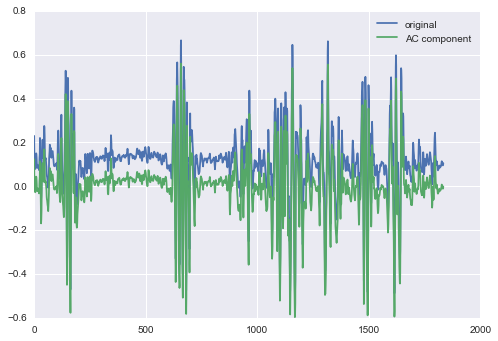

In [20]:
#plt.plot(x_restored_list[0])
#plt.plot(y_restored_list[0])
#plt.plot(z_restored_list[0])
#plt.plot(originalX[files[0]])
#plt.plot(originalY[files[0]])
m = np.mean(originalZ[files[0]])
plt.plot(originalZ[files[0]], label='original')
plt.plot(np.array(originalZ[files[0]])-m, label='AC component')

plt.legend()
z_restored_list[0] == originalZ[files[0]]

## Preprocessing

In [21]:
x_sig_segments_AC = []
y_sig_segments_AC = []
z_sig_segments_AC = []
#mag_segments_AC = []

x_sig_segments_AC_BWFILTER = []
y_sig_segments_AC_BWFILTER = []
z_sig_segments_AC_BWFILTER = []
mag_segments_AC_BWFILTER = []


### COMPUTE AC COMPONENT FOR X, Y, Z AS WELL AS MAG VECTOR OF THE SEGMENT.
for i in range(len(z_sig_segments)): ## the number of segments are the same for all axes.

    # Butterworth filter properties
    # Correct the cutoff frequency for the number of passes in the filter
    C = 0.802
    freq = sig_frequences[i]   # file segment frequency
    b, a = butter(3, (5/C)/(freq/2), btype = 'low') # order 3
    
    ## for x axis
    m = np.mean(x_sig_segments[i])
    acx = np.array(x_sig_segments[i]) - m
    x_sig_segments_AC.append(acx)
    # applying butterworth filter for x axis
    x_sig_segments_AC_BWFILTER.append(filtfilt(b, a, acx))  # filter with phase shift correction
    
    ## for y axis
    m = np.mean(y_sig_segments[i])
    acy = np.array(y_sig_segments[i]) - m
    y_sig_segments_AC.append(acy)
    # applying butterworth filter for y axis
    y_sig_segments_AC_BWFILTER.append(filtfilt(b, a, acy))  # filter with phase shift correction
    
    ## for z axis
    m = np.mean(z_sig_segments[i])
    acz = np.array(z_sig_segments[i]) - m
    z_sig_segments_AC.append(acz)
    # applying butterworth filter for z axis
    z_sig_segments_AC_BWFILTER.append(filtfilt(b, a, acz))  # filter with phase shift correction
    
    assert len(acx) == len(acy) == len(acz)
    seg_mag = []
    for e in range(len(acx)):
        seg_mag.append(np.sqrt(acx[e]**2 + acy[e]**2 + acz[e]**2))
    mag_segments_AC_BWFILTER.append(seg_mag)
    
    
    

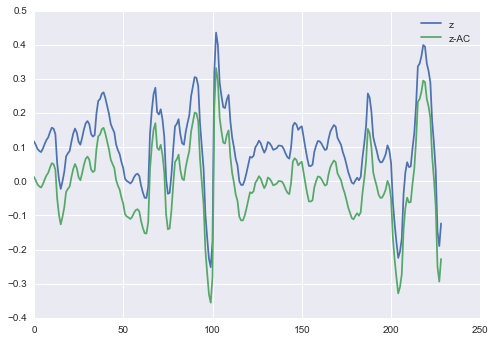

In [22]:
plt.plot(z_sig_segments[0], label = 'z')
plt.plot(z_sig_segments_AC[0], label = 'z-AC')
plt.legend()
plt.show()

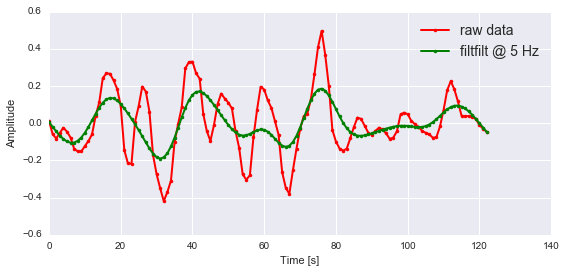

In [24]:
# plot
fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))
ax1.plot(z_sig_segments_AC[600], 'r.-', linewidth=2, label = 'raw data')
ax1.plot(z_sig_segments_AC_BWFILTER[600], 'g.-', linewidth=2, label = 'filtfilt @ 5 Hz')
ax1.legend(frameon=False, fontsize=14)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
plt.show()

In [25]:
correlation(z_sig_segments_AC_BWFILTER[6],x_sig_segments_AC_BWFILTER[6])

-0.66628035282414166

## Testing butterworth

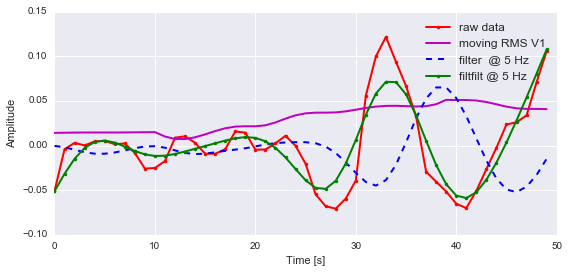

In [26]:

seg_number = 400
window = 10
freq = sig_frequences[seg_number]
y = z_sig_segments_AC[seg_number]

# Butterworth filter
b, a = butter(3, 5/(freq/2), btype = 'low')
y2 = lfilter(b, a, y)  # standard filter
# Correct the cutoff frequency for the number of passes in the filter
C = 0.802
b, a = butter(3, (5/C)/(freq/2), btype = 'low')
y3 = filtfilt(b, a, y)  # filter with phase shift correction

y1 = moving_rmsV1(y3, window)

# plot
fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))
ax1.plot(y, 'r.-', linewidth=2, label = 'raw data')
ax1.plot(y1, 'm-',  linewidth=2, label = 'moving RMS V1')
ax1.plot(y2, 'b--', linewidth=2, label = 'filter  @ 5 Hz')
ax1.plot(y3, 'g.-', linewidth=2, label = 'filtfilt @ 5 Hz')
ax1.legend(frameon=False, fontsize=12)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
plt.show()

## Find peaks

avg: 0.00080214933903


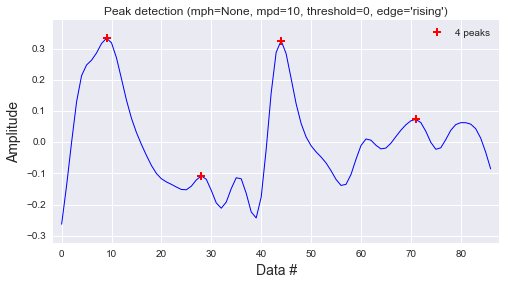

avg ind: 0.156002547013


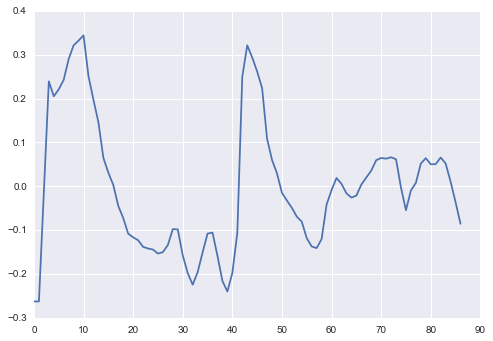

In [25]:
seg_number = 50
m = np.mean(z_sig_segments_AC_BWFILTER[seg_number])
print 'avg: {}'.format(m)
ind = detect_peaks(z_sig_segments_AC_BWFILTER[seg_number], mpd=10, show=True)
print 'avg ind: {}'.format(np.mean([z_sig_segments_AC_BWFILTER[seg_number][i] for i in ind]))
plt.plot(z_sig_segments_AC[seg_number])

In [26]:
#gridOfPlots(sig_segments[:50])
#gridOfFFT(sig_segments[:50], 50)

## Vectorize segments using metafeatures

In [27]:
## metafeatures list to be computed
#to_compute = ["mean","std","max","min","mad","sma","iqr","rms","num_peaks","maxInds","skewness","kurtosis","freq_skewness","freq_kurtosis"]
#to_compute = ["mean","std","mad","sma","iqr","max_min","skewness","kurtosis"]
to_compute = ["num_peaks", "rms"]#, "max_min"]
x_meta_vectors = []
y_meta_vectors = []
z_meta_vectors = []

#### CALCULATE A CORRELATION ###
correlationxy =[]
correlationxz =[]
correlationyz =[]

lengths = []

for s in range(len(z_sig_segments_AC_BWFILTER)):
    correlationxy.append(correlation(x_sig_segments_AC_BWFILTER[s], y_sig_segments_AC_BWFILTER[s]))
    correlationxz.append(correlation(x_sig_segments_AC_BWFILTER[s], z_sig_segments_AC_BWFILTER[s]))
    correlationyz.append(correlation(y_sig_segments_AC_BWFILTER[s], z_sig_segments_AC_BWFILTER[s]))
    lengths.append(len(z_sig_segments_AC_BWFILTER[s]))
    
for s in x_sig_segments:
    x_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
for s in y_sig_segments:
    y_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
for s in z_sig_segments_AC_BWFILTER:
    z_meta_vectors.append(get_metafeat_vector(s, mf=to_compute).values())
#X = np.matrix(meta_vectors)
#X = np.matrix([i + [j] for i,j in zip(segment_fft,[max_value(x)-min_value(x) for x in sig_segments])])
#max_min = np.array([max_value(x)-min_value(x) for x in sig_segments])
#A = np.column_stack((np.array(segment_fft), max_min))
#A = np.column_stack((np.array(A), meta_vectors))
#A = np.column_stack((np.array(segment_fft), meta_vectors))
#X = np.column_stack((np.array(x_meta_vectors), np.array(y_meta_vectors),np.array(z_meta_vectors)))
#X = np.column_stack((np.array(x_segment_fft), np.array(y_segment_fft),np.array(z_segment_fft)))
#print np.array(mag_segments_AC_BWFILTER).shape
#X = np.column_stack((np.array(x_meta_vectors), np.array(y_meta_vectors),np.array(z_meta_vectors), lengths, correlationxy, correlationxz, correlationyz))
X = np.column_stack((x_meta_vectors, y_meta_vectors, z_meta_vectors,lengths))
#X = np.matrix(A)
#X = np.matrix(y_meta_vectors)
print X.shape

(623, 7)


#### Standard score normalization or Z-normalization:

In [28]:
X_normed = (X - X.mean(axis=0)) / X.std(axis=0)
#print X_normed
X = X_normed

## Perform the Hierarchical Clustering

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = None
# Check the Cophenetic Correlation Coefficient of the clustering 
# with help of the cophenet() function. This (very very briefly)
# compares (correlates) the actual pairwise distances of all samples 
# to those implied by the hierarchical clustering. The closer the value
# is to 1, the better the clustering preserves the original distances.
for t in ['ward','single', 'complete', 'average']:
    # generate the linkage matrix
    Z = linkage(X, t)
    c, coph_dists = cophenet(Z, pdist(X))#, 'cosine'))
    print 'Linkage {} has a Cophenetic Correlation Coefficient of {}'.format(t,c)
Z = linkage(X,'average')

Linkage ward has a Cophenetic Correlation Coefficient of 0.628497214342
Linkage single has a Cophenetic Correlation Coefficient of 0.764876154819
Linkage complete has a Cophenetic Correlation Coefficient of 0.696402463346
Linkage average has a Cophenetic Correlation Coefficient of 0.815621907623


In [30]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

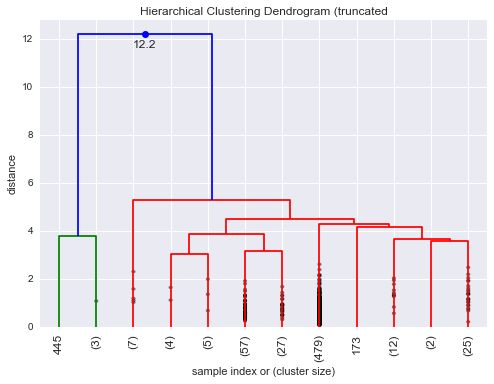

In [31]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

## Get clusters by distance

In [32]:
from scipy.cluster.hierarchy import fcluster
max_d = 4
clusters = fcluster(Z, max_d, criterion='distance')
print Counter(clusters)

Counter({4: 479, 3: 93, 5: 39, 2: 7, 1: 4, 6: 1})


<IPython.core.display.Javascript object>


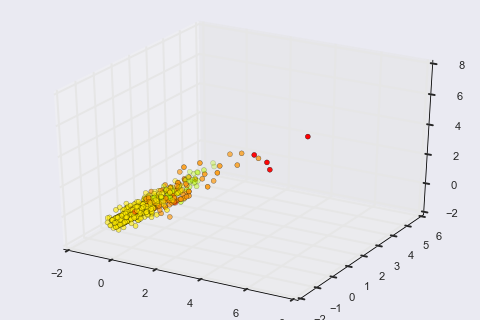

In [34]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:,0].tolist(), X[:,1].tolist(), X[:,2].tolist(), c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

## Get clusters by max number

In [ ]:
from scipy.cluster.hierarchy import fcluster
k=11
result = fcluster(Z, k, criterion='maxclust')
print Counter(result)

## Framming corpus

In [35]:
ranks = [i for i in range(len(z_sig_segments))]

df = {'sym_segments':sym_segments,
      'cluster':clusters,
      'rank':ranks,
      'x_sig_segments':x_sig_segments,
      'y_sig_segments':y_sig_segments,
      'z_sig_segments':z_sig_segments,
      'sig_file_map':sig_file_map,
      'sym_file_map':sym_file_map,
      'alignment': succ_alignments
     }

frame = pd.DataFrame(df, index = [clusters] , columns = ['sym_segments','cluster','rank','x_sig_segments',
                                                         'y_sig_segments','z_sig_segments',
                                                         'sig_file_map','sym_file_map', 'alignment'])
assert frame['sig_file_map'].equals(frame['sym_file_map'])
print 'Cluster counts: '
frame['cluster'].value_counts()

Cluster counts: 


4    479
3     93
5     39
2      7
1      4
6      1
Name: cluster, dtype: int64

## Save to pickle

In [36]:
# open the file for writing
file_name = 'cluster_info_matrix.pkl'
file_object = open(file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

pickle DONE!


In [ ]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

## Multidimensional scaling

In [ ]:
from sklearn.manifold import MDS

MDS()
# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

## Visualizing document clusters

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5'}

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(len(sym_segments)))) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Save to pickle

In [ ]:
# open the file for writing
file_name = 'cluster_info_matrix.pkl'
file_object = open(file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

## Cluster's members

In [ ]:
grid_side_size = 5
fig, axes = plt.subplots(4, grid_side_size, figsize=(20,9))

first_50 = defaultdict(list)
for ind,c in enumerate(clusters):
    axes[0][c].plot(sig_segments[ind])
    axes[0][c].set_title('Cluster {}'.format(c))
    first_50[c].append(sig_segments[ind][:50])
    
for c,l in first_50.iteritems():
    sig = np.matrix(l)
    mean_of_sig = np.mean(sig,axis=0).tolist()[0]
    std_of_sig  = np.std(sig,axis=0).tolist()[0]
    axes[1][c].errorbar(range(len(mean_of_sig)),mean_of_sig,yerr=std_of_sig, fmt='-o', ecolor='r')
    axes[1][c].set_title('Mean of first 50 pts - Cluster {}'.format(c))
    axes[1][c].plot(mean_of_sig, c='m')
    
N_fft = 100 # FFT number of bins
Fs = 100 # Frequence range we are interested

for c,l in first_50.iteritems():
    # getting the signal (the mean value of each 50-length segment in the cluster). Assumed to be the
    # mean of the cluster.
    sig = np.mean(np.matrix(l),axis=0).tolist()[0]
    mean_sig = np.ones_like(sig)*np.mean(sig)
    # remove mean of the signal, for better results.
    sig = sig - mean_sig
    ### FFT
    freqsig = fft.fft(sig, n=N_fft)
    freq_axis = np.arange(0, Fs, Fs / N_fft)
    axes[2][c].plot(freq_axis, np.abs(freqsig), lw=2.0, c='b')
    p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
    axes[2][c].add_patch(p)
    axes[2][c].set_xlim((-2,Fs))
    axes[2][c].set_xlim((-2,Fs))
    axes[2][c].set_title("FFT - Cluster{}".format(c), fontsize=10)
    axes[2][c].set_ylabel('Power')
    axes[2][c].set_xlabel('Frequency (Hz)')
    axes[2][c].legend((p,), ('excluded',))
    axes[2][c].grid()

for cc in range(len(cluster_centers)):
    axes[3][cc].plot(cluster_centers[cc])
    axes[3][cc].set_title('Centroid of cluster {}'.format(cc))
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.8, wspace=0.5)
plt.draw()

## Hierarchical document clustering

Now that I was successfuly able to cluster and plot the documents using k-means, I wanted to try another clustering algorithm. I chose the [Ward clustering algorithm](http://en.wikipedia.org/wiki/Ward%27s_method) because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. I used the precomputed cosine distance matrix (*dist*) to calculate a linkage_matrix, which I then plot as a dendrogram. 

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(12, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=range(len(segments)))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## T-sne

In [ ]:
%%time

from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(smatrix.todense())
Y = svd.fit_transform(smatrix.todense()) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1.1])
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=frame.index)
print(dfsvd.shape)
dfsvd.head()

In [ ]:
plotdims = 5
ploteorows = 1
svdcols = [c for c in dfsvd.columns if c[0] == 'c']
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['cluster'] = frame['cluster']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='cluster', size=2.5)


In [ ]:
Z = TSNE().fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

In [ ]:
dftsne['cluster'] = frame['cluster']
g = sns.lmplot('x', 'y', dftsne, hue='cluster', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 20D dataset reduced to 2D using t-SNE')

## With DBSCAN

In [ ]:
from sklearn.cluster import dbscan
db_a = dbscan(tfidf_matrix,eps=0.60, min_samples=3)
clusters = db_a[1].tolist()
ranks = [i for i in range(len(segments))]
ndf = {'indexes' : range(len(segments)), 'segments': segments,'cluster': clusters, 'rank': ranks}
nframe = pd.DataFrame(ndf, index = [clusters] , columns = ['indexes','segments','cluster','rank'])
nframe['cluster'].value_counts()

In [ ]:
ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(smatrix.todense())
Y = svd.fit_transform(smatrix.todense()) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1.1])
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=nframe.index)
print(dfsvd.shape)
dfsvd.head()

In [ ]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['cluster'] = nframe['cluster']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='cluster', size=2.5)

In [ ]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']
Z = TSNE().fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

In [ ]:
dftsne['cluster'] = nframe['cluster']
g = sns.lmplot('x', 'y', dftsne, hue='cluster', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 20D dataset reduced to 2D using t-SNE')